In [1]:
import pandas as pd

In [2]:
from preprocessing.transformers import make_empty_values_filler_pipeline

In [3]:
shares = pd.read_csv("../shares.csv")
etfs = pd.read_csv("../etfs.csv")
bonds = pd.read_csv("../bonds.csv")
currencies = pd.read_csv("../currencies.csv")

In [4]:
shares_cat_columns = shares.dtypes[shares.dtypes == "object"].index.tolist()
shares_num_columns = shares.dtypes[shares.dtypes != "object"].index.tolist()

etfs_cat_columns = etfs.dtypes[etfs.dtypes == "object"].index.tolist()
etfs_num_columns = etfs.dtypes[etfs.dtypes != "object"].index.tolist()

bonds_cat_columns = bonds.dtypes[bonds.dtypes == "object"].index.tolist()
bonds_num_columns = bonds.dtypes[bonds.dtypes != "object"].index.tolist()

In [5]:
shares_nan_filler = make_empty_values_filler_pipeline(
    num_columns=shares_num_columns,
    cat_columns=shares_cat_columns
)
bonds_nan_filler = make_empty_values_filler_pipeline(
    num_columns=bonds_num_columns,
    cat_columns=bonds_cat_columns
)
etfs_nan_filler = make_empty_values_filler_pipeline(
    num_columns=etfs_num_columns,
    cat_columns=etfs_cat_columns
)

In [6]:
filled_bonds = bonds_nan_filler.fit_transform(bonds)
filled_bonds = pd.DataFrame(filled_bonds, columns=(bonds_num_columns + bonds_cat_columns))

filled_etfs = etfs_nan_filler.fit_transform(etfs)
filled_etfs = pd.DataFrame(filled_etfs, columns=(etfs_num_columns + etfs_cat_columns))

filled_shares = shares_nan_filler.fit_transform(shares)
filled_shares = pd.DataFrame(filled_shares, columns=(shares_num_columns + shares_cat_columns))

In [7]:
from datetime import datetime


shares_with_rating = filled_shares.copy()
bonds_with_rating = filled_bonds.copy()
etfs_with_rating = filled_etfs.copy()

shares_with_rating.ipo_date = pd.to_datetime(shares_with_rating.ipo_date, format="%d/%m/%Y")
bonds_with_rating.maturity_date = pd.to_datetime(bonds_with_rating.maturity_date, format="%d/%m/%Y")

def normalize(series):
    return 10 * (series - series.min()) / (series.max() - series.min())


def country_risk_score(country):
    if country == 'RU':
        return 10
    elif country == 'US':
        return 8
    elif country in ['DE', 'FR', 'EU']:
        return 6
    elif country == 'CN':
        return 4
    elif country == 'KZ':
        return 5
    else:
        return 2


def rebalancing_freq_score(freq):
    if freq == 'daily':
        return 10
    elif freq == 'quarterly':
        return 8
    elif freq == 'semi_annual':
        return 5
    elif freq == 'annual':
        return 3
    else:
        return 0 


def focus_type_score(focus_type):
    if focus_type == 'equity':
        return 10
    elif focus_type == 'fixed_income':
        return 8
    elif focus_type == 'mixed_allocation':
        return 6
    elif focus_type == 'commodity':
        return 4
    elif focus_type == 'alternative_investment':
        return 2
    else:
        return 0

normed_shares = {
    "issue_size": normalize(shares_with_rating['issue_size']),
    "ipo_date": normalize((datetime.now() - shares_with_rating['ipo_date']).apply(lambda x: x.days))
}
normed_etfs = {
    "fixed_commission": normalize(etfs_with_rating['fixed_commission']),
    "num_shares": normalize(etfs_with_rating['num_shares'])
}

normed_bonds = {
    "coupon_quantity_per_year": normalize(bonds_with_rating['coupon_quantity_per_year']),
    "maturity_date": normalize((bonds_with_rating["maturity_date"] - datetime.now()).apply(lambda x: x.days)),
    "issue_size": normalize(bonds_with_rating['issue_size']),
}

def calculate_shares_rating(row):
    liquidity = 10 if row['liquidity_flag'] else 0
    country_risk = country_risk_score(row['country_of_risk'])
    issue_size = normed_shares['issue_size'][row.name]
    ipo_days = 10 - normed_shares['ipo_date'][row.name]
    
    return 0.3 * liquidity + 0.2 * country_risk + 0.3 * issue_size + 0.2 * ipo_days


def calculate_etfs_rating(row):
    rebalancing_freq = rebalancing_freq_score(row['rebalancing_freq'])
    fixed_commission = 10 - normed_etfs['fixed_commission'][row.name]
    focus_type = focus_type_score(row['focus_type'])
    num_shares = normed_etfs['num_shares'][row.name]

    return 0.25 * rebalancing_freq + 0.25 * fixed_commission + 0.3 * focus_type + 0.2 * num_shares


def calculate_bonds_rating(row):
    coupon_quantity = normalize(filled_bonds['coupon_quantity_per_year'])[row.name]
    maturity_date = 10 - normed_bonds["maturity_date"][row.name]
    country_risk = country_risk_score(row['country_of_risk'])
    issue_size = normalize(filled_bonds['issue_size'])[row.name]
    # print(f"{coupon_quantity=}, {maturity_date=}, {country_risk=}, {issue_size=}, {coupon_rate=}")
    return (0.25 * coupon_quantity +
            0.2 * maturity_date +
            0.25 * country_risk +
            0.2 * issue_size)


shares_with_rating['Rating'] = shares_with_rating.apply(calculate_shares_rating, axis=1)
etfs_with_rating['Rating'] = etfs_with_rating.apply(calculate_etfs_rating, axis=1)
bonds_with_rating['Rating'] = bonds_with_rating.apply(calculate_bonds_rating, axis=1)

print("Shares Ratings:\n", shares_with_rating[['ticker', 'Rating']].head())
print("ETFs Ratings:\n", etfs_with_rating[['ticker', 'Rating']].head())
print("Bonds Ratings:\n", bonds_with_rating[['ticker', 'Rating']].head())


Shares Ratings:
   ticker    Rating
0    CNX  2.628355
1    SLM  2.628429
2   ACLS  5.628217
3   AMPH  5.628228
4   RELY  5.628319
ETFs Ratings:
   ticker    Rating
0    GDX  7.603690
1    TIP  7.550363
2    RSP  7.501144
3   AKMM  5.100000
4   SOXS  7.500000
Bonds Ratings:
          ticker    Rating
0  RU000A107D74  6.207231
1  RU000A101RZ3  2.808224
2  RU000A102R73  4.124508
3  RU000A102D46  4.185572
4  RU000A1022E6  6.155101


In [8]:
etfs_with_rating.sort_values('Rating', ascending=False)

,fixed_commission,num_shares,min_price_increment,lot,price,rub_price,figi,ticker,class_code,isin,currency,name,exchange,focus_type,released_date,country_of_risk,country_of_risk_name,sector,rebalancing_freq,Rating
20,0.07,1777635515.0,0.01,1.0,46.61,0.0,BBG000HT88C8,VWO,SPBXM,US9220428588,usd,Vanguard FTSE Emerging Markets ETF,unknown,equity,10/03/2005,US,Соединенные Штаты Америки,other,quarterly,9.441667
128,0.07,1724292560.0,0.01,1.0,50.1,0.0,BBG000QVFB47,VEA,SPBXM,US9219438580,usd,Vanguard FTSE Developed Markets ETF,unknown,equity,26/07/2007,US,Соединенные Штаты Америки,other,quarterly,9.381651
186,0.04,890245427.0,0.01,1.0,46.5,0.0,BBG000BJ29X7,XLF,SPBXM,US81369Y6059,usd,The Financial Select Sector SPDR Fund,unknown,equity,22/12/1998,US,Соединенные Штаты Америки,financial,quarterly,8.468273
30,0.0945,929082116.0,0.01,1.0,569.44,0.0,BBG000BDTBL9,SPY,SPBXM,US78462F1030,usd,SPDR S&P 500 ETF Trust,unknown,equity,22/01/1993,US,Соединенные Штаты Америки,other,quarterly,8.466551
235,0.03,758456843.0,0.01,1.0,281.29,0.0,BBG000HR9779,VTI,SPBXM,US9229087690,usd,Vanguard Total Stock Market ETF,unknown,equity,31/05/2001,US,Соединенные Штаты Америки,other,quarterly,8.328332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,2.0,0.0,0.01,1.0,8.79,8.79,TCS00A107563,TDIV,TQTF,RU000A107563,rub,Дивидендные акции,moex_etf_evening,equity,12/10/2023,RU,Российская Федерация,other,annual,4.583333
178,0.0,0.0,0.01,1.0,30.88,0.0,TCS0214Q7088,ARKF,SPBXM,US00214Q7088,usd,ARK Fintech Innovation ETF,unknown,money_market,01/01/1970,US,Соединенные Штаты Америки,financial,quarterly,4.500000
85,0.4,266900000.0,0.01,1.0,253.26,0.0,BBG000CRF6Q8,GLD,SPBXM,US78463V1070,usd,SPDR Gold Trust,unknown,commodity,18/11/2004,US,Соединенные Штаты Америки,materials,annual,4.416953
259,2.0,0.0,0.01,1.0,10.95,10.95,TCS10A101X50,TGLD,TQTF,RU000A101X50,rub,Золото,moex_etf,alternative_investment,13/07/2020,RU,Российская Федерация,other,quarterly,3.433333


In [9]:
filled_shares.isna().sum().sort_values(ascending=False)

nominal                 0
issue_size              0
country_of_risk_name    0
country_of_risk         0
ipo_date                0
exchange                0
name                    0
currency                0
isin                    0
class_code              0
ticker                  0
figi                    0
rub_price               0
price                   0
lot                     0
liquidity_flag          0
issue_size_plan         0
sector                  0
dtype: int64

In [10]:
etfs_with_rating.sort_values('Rating')

,fixed_commission,num_shares,min_price_increment,lot,price,rub_price,figi,ticker,class_code,isin,currency,name,exchange,focus_type,released_date,country_of_risk,country_of_risk_name,sector,rebalancing_freq,Rating
132,2.0,0.0,0.01,1.0,7.88,7.88,BBG000000001,TRUR,TQTF,RU000A1011U5,rub,Вечный портфель,moex_etf,mixed_allocation,07/11/2019,RU,Российская Федерация,other,annual,3.383333
259,2.0,0.0,0.01,1.0,10.95,10.95,TCS10A101X50,TGLD,TQTF,RU000A101X50,rub,Золото,moex_etf,alternative_investment,13/07/2020,RU,Российская Федерация,other,quarterly,3.433333
85,0.4,266900000.0,0.01,1.0,253.26,0.0,BBG000CRF6Q8,GLD,SPBXM,US78463V1070,usd,SPDR Gold Trust,unknown,commodity,18/11/2004,US,Соединенные Штаты Америки,materials,annual,4.416953
178,0.0,0.0,0.01,1.0,30.88,0.0,TCS0214Q7088,ARKF,SPBXM,US00214Q7088,usd,ARK Fintech Innovation ETF,unknown,money_market,01/01/1970,US,Соединенные Штаты Америки,financial,quarterly,4.500000
165,2.0,0.0,0.01,1.0,8.79,8.79,TCS00A107563,TDIV,TQTF,RU000A107563,rub,Дивидендные акции,moex_etf_evening,equity,12/10/2023,RU,Российская Федерация,other,annual,4.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.03,758456843.0,0.01,1.0,281.29,0.0,BBG000HR9779,VTI,SPBXM,US9229087690,usd,Vanguard Total Stock Market ETF,unknown,equity,31/05/2001,US,Соединенные Штаты Америки,other,quarterly,8.328332
30,0.0945,929082116.0,0.01,1.0,569.44,0.0,BBG000BDTBL9,SPY,SPBXM,US78462F1030,usd,SPDR S&P 500 ETF Trust,unknown,equity,22/01/1993,US,Соединенные Штаты Америки,other,quarterly,8.466551
186,0.04,890245427.0,0.01,1.0,46.5,0.0,BBG000BJ29X7,XLF,SPBXM,US81369Y6059,usd,The Financial Select Sector SPDR Fund,unknown,equity,22/12/1998,US,Соединенные Штаты Америки,financial,quarterly,8.468273
128,0.07,1724292560.0,0.01,1.0,50.1,0.0,BBG000QVFB47,VEA,SPBXM,US9219438580,usd,Vanguard FTSE Developed Markets ETF,unknown,equity,26/07/2007,US,Соединенные Штаты Америки,other,quarterly,9.381651


In [4]:
from preprocessing.rating import SecurityRating

In [10]:
rating = SecurityRating(
    bonds=bonds,
    etfs=etfs,
    shares=shares
)

issue_size
ipo_date
fixed_commission
num_shares
coupon_quantity_per_year
maturity_date
issue_size


In [11]:
bonds_rating = bonds.apply(rating.calculate_bonds_rating, axis=1)
etfs_rating = etfs.apply(rating.calculate_etfs_rating, axis=1)
shares_rating = shares.apply(rating.calculate_shares_rating, axis=1)

<Axes: ylabel='Frequency'>

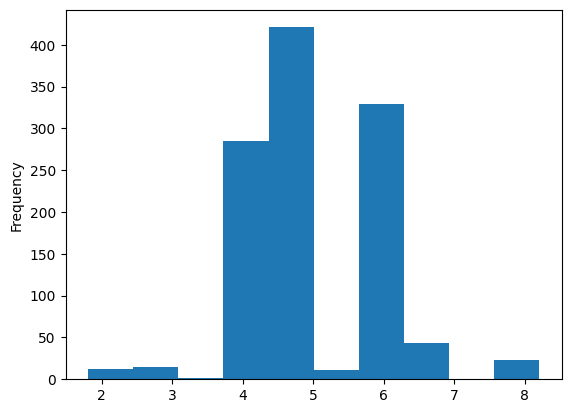

In [12]:
bonds_rating.plot(kind="hist")

<Axes: ylabel='Frequency'>

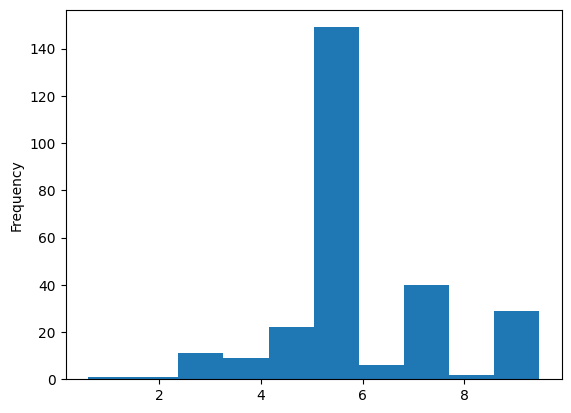

In [13]:
etfs_rating.plot(kind="hist")

<Axes: ylabel='Frequency'>

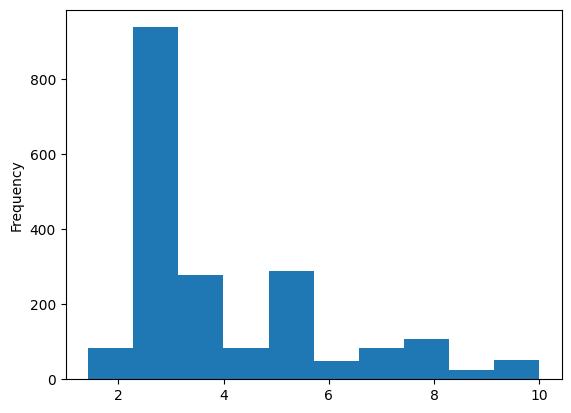

In [14]:
shares_rating.plot(kind="hist")

In [3]:
bonds_rating = pd.read_csv("../bonds_price_ratings.csv")

In [4]:
bonds_rating.columns

Index(['mean_return', 'volatility', 'max_drawdown', 'sharpe_ratio',
       'sortino_ratio', 'trend_slope', 'figi'],
      dtype='object')

In [6]:
from preprocessing.rating import NormalizedData

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
bonds_normed_rating = NormalizedData(bonds_rating, keys=bonds_rating.columns)

TypeError: ufunc 'divide' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [14]:
bonds_rating[~bonds_rating.mean_return.isna()]

,mean_return,volatility,max_drawdown,sharpe_ratio,sortino_ratio,trend_slope,figi
0,-0.000281,0.004423,-0.102913,-0.083061,-0.115683,-0.000372,TCS00A107D74
1,-0.001062,0.004978,-0.244430,-0.229078,-0.296018,-0.001000,BBG00XH4W3N3
2,-0.000785,0.022245,-0.243511,-0.039054,-0.052588,-0.001243,BBG00Z8KGGC3
3,-0.000972,0.007070,-0.225787,-0.149381,-0.181170,-0.001006,TCS00A102D46
4,-0.000055,0.002884,-0.054023,-0.046404,-0.060409,-0.000042,ISSUANCEPRLS
...,...,...,...,...,...,...,...
1134,-0.000242,0.005859,-0.102303,-0.054752,-0.077988,-0.000308,TCS00A105Q63
1135,-0.000391,0.006314,-0.103209,-0.074375,-0.099166,-0.000261,BBG012YS2TP2
1136,0.000116,0.002707,-0.018288,0.013845,0.018995,0.000116,TCS00A105HJ9
1138,-0.000234,0.002923,-0.066396,-0.107028,-0.163617,-0.000165,TCS00A104735
